In [1]:
import numpy as np 
import pandas as pd 

# Reading the dataset
raw_train = pd.read_csv("train.csv")
raw_test = pd.read_csv("test.csv")

train = raw_train.drop(['id','target'], axis = 1)
test = raw_test.drop('id', axis = 1)

target = raw_train.target
id_train = raw_train.id
id_test = raw_test.id


# -----------------------------------------------------------------
# Some parameters to config 

EPOCHS = 20
BATCH_SIZE = 2048 
ACTIVATION = 'swish'
LEARNING_RATE = 0.000265713
FOLDS = 5

To begin I split the dataset by distribution of each column and added some basic columns (mea, std, var, mean, etc).

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# the number 2 is just a threshold to split 
h_skew = train.loc[:,train.skew() >= 2].columns  # with Skewed 
l_skew = train.loc[:,train.skew() < 2].columns   # Bimodal

# -----------------------------------------------------------------
# Skewed distrubutions

# train['mean_h'] = train[h_skew].mean(axis=1)
# test['mean_h'] = test[h_skew].mean(axis=1)

# train['std_h'] = np.log1p(train[h_skew].std(axis=1))
# test['std_h'] = np.log1p(test[h_skew].std(axis=1))

train['median_h'] = train[h_skew].median(axis=1)
test['median_h'] = test[h_skew].median(axis=1)

# train['min_h'] = train[h_skew].min(axis=1)
# test['min_h'] = test[h_skew].min(axis=1)

# train['skew_h'] = train[h_skew].skew(axis=1)
# test['skew_h'] = test[h_skew].skew(axis=1)

# train['max_h'] = train[h_skew].max(axis=1)
# test['max_h'] = test[h_skew].max(axis=1)

train['var_h'] = train[h_skew].var(axis=1)
test['var_h'] = test[h_skew].var(axis=1)

# Bimodal distributions

train['mean_l'] = train[l_skew].mean(axis=1)
test['mean_l'] = test[l_skew].mean(axis=1)

train['std_l'] = train[l_skew].std(axis=1)
test['std_l'] = test[l_skew].std(axis=1)

train['median_l'] = train[l_skew].median(axis=1)
test['median_l'] = test[l_skew].median(axis=1)

# train['min_l'] = train[l_skew].min(axis=1)
# test['min_l'] = test[l_skew].min(axis=1)

train['skew_l'] = train[l_skew].skew(axis=1)
test['skew_l'] = test[l_skew].skew(axis=1)

train['max_l'] = train[l_skew].max(axis=1)

test['max_l'] = test[l_skew].max(axis=1)

train['var_l'] = train[l_skew].var(axis=1)
test['var_l'] = test[l_skew].var(axis=1)


raw_train = train.copy()
raw_test = test.copy()

# -----------------------------------------------------------------
# Scaling and Nomalization

transformer_high_skew = make_pipeline(
    StandardScaler(), 
    MinMaxScaler(feature_range=(0, 1))
)

transformer_low_skew = make_pipeline(
    StandardScaler(),
    MinMaxScaler(feature_range=(0, 1))
)

new_cols = train.columns[-8:]

transformer_new_cols = make_pipeline(
    StandardScaler(),
    MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_high_skew, l_skew),
    (transformer_low_skew, h_skew),
    (transformer_new_cols, new_cols),
)

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import warnings 
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppressing GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"]='1'# GPU using on

import tensorflow as tf
import random
import os

def load_model(name:str):
    
    early_stopping = callbacks.EarlyStopping(
        patience=20,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=1,
        mode='min', 
        baseline=None,
    )

    plateau = callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=7, 
            verbose=0,
            mode='min')

# -----------------------------------------------------------------
# Model 

    model = keras.Sequential([
        layers.Dense(108, activation = ACTIVATION, input_shape = [train.shape[1]]),      
        layers.Dense(64, activation =ACTIVATION), 
        layers.Dense(32, activation =ACTIVATION),
        layers.Dense(1, activation='sigmoid'),
    ])
# -----------------------------------------------------------------

    model.compile(
        optimizer= keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['AUC'],
    )
    
    return model, early_stopping, plateau

In [4]:
EPOCHS=20

In [5]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer

preds_valid_f = {}
preds_test = []
total_auc = []
f_scores = []

kf = StratifiedKFold(n_splits=FOLDS,random_state=0,shuffle=True)

for fold,(train_index, valid_index) in enumerate(kf.split(train,target)):

    X_train,X_valid = train.loc[train_index], train.loc[valid_index]
    y_train,y_valid = target.loc[train_index], target.loc[valid_index]

    #   --------------------------------------------------------  
    # Preprocessing
    index_valid  = X_valid.index.tolist()
    test  = raw_test.copy()
    
    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    test = preprocessor.transform(test)
    #  ----------------------------------------------------------    
    # Model
    
    model, early_stopping, plateau  = load_model('version1')

    history = model.fit(  X_train, y_train,
                validation_data = (X_valid, y_valid),
                batch_size = BATCH_SIZE, 
                epochs = EPOCHS,
                callbacks = [early_stopping, plateau],
                shuffle = True,
                verbose = 1
              )

    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid).reshape(1,-1)[0] 
    
    #  ----------------------------------------------------------
    #  test  predictions
    preds_test.append(model.predict(test).reshape(1,-1)[0])
    
    #  ----------------------------------------------------------
    #  Saving  scores to plot the end  
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    if fold == 0:
        f_scores = scores 
    else: 
        f_scores = pd.concat([f_scores, scores], axis  = 0)
        
    #  ----------------------------------------------------------
    #  concatenating valid preds
    preds_valid_f.update(dict(zip(index_valid, preds_valid)))

    # Getting score for a fold model
    fold_auc = roc_auc_score(y_valid, preds_valid)
    print(f"Fold {fold} roc_auc_score: {fold_auc}")

    # Total auc
    total_auc.append(fold_auc)

print(f"mean roc_auc_score: {np.mean(total_auc)}, std: {np.std(total_auc)}")

Epoch 1/20
235/235 [==============================] - 2s 5ms/step - loss: 0.6478 - auc: 0.6916 - val_loss: 0.6203 - val_auc: 0.7260 - lr: 2.6571e-04
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.6187 - auc: 0.7284 - val_loss: 0.6181 - val_auc: 0.7308 - lr: 2.6571e-04
Epoch 3/20
235/235 [==============================] - 1s 4ms/step - loss: 0.6171 - auc: 0.7312 - val_loss: 0.6162 - val_auc: 0.7331 - lr: 2.6571e-04
Epoch 4/20
235/235 [==============================] - 1s 4ms/step - loss: 0.6155 - auc: 0.7336 - val_loss: 0.6149 - val_auc: 0.7349 - lr: 2.6571e-04
Epoch 5/20
235/235 [==============================] - 1s 4ms/step - loss: 0.6144 - auc: 0.7355 - val_loss: 0.6140 - val_auc: 0.7364 - lr: 2.6571e-04
Epoch 6/20
235/235 [==============================] - 1s 4ms/step - loss: 0.6138 - auc: 0.7365 - val_loss: 0.6149 - val_auc: 0.7378 - lr: 2.6571e-04
Epoch 7/20
235/235 [==============================] - 1s 4ms/step - loss: 0.6129 - auc: 0.7379 - val_loss:

Validation Loss: 0.5954
Validation Loss: 0.5935
Validation Loss: 0.6095
Validation Loss: 0.6068
Validation Loss: 0.5929


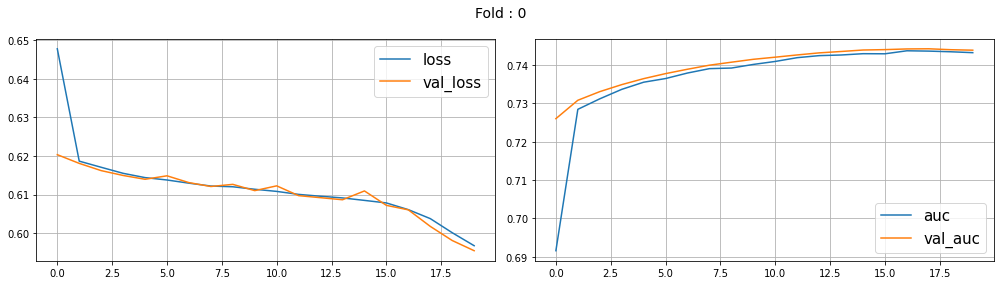

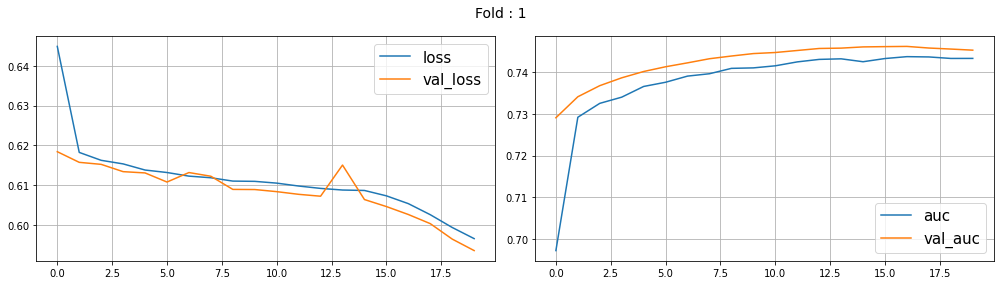

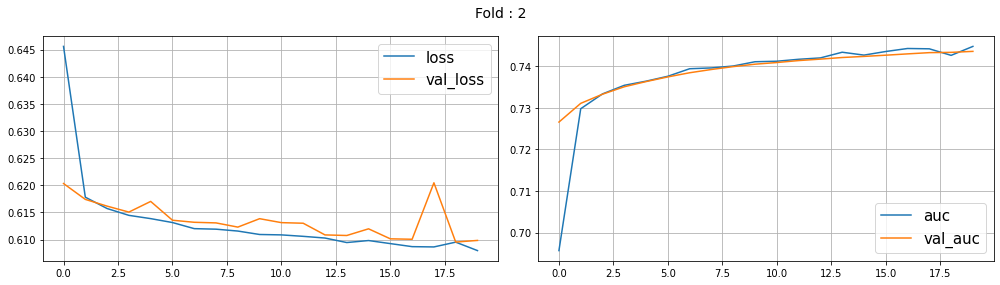

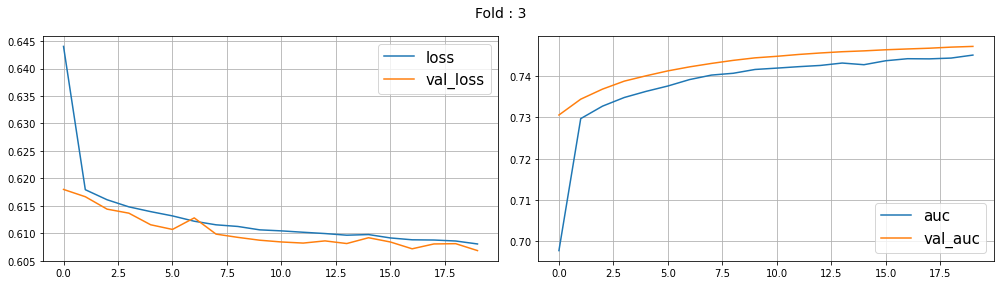

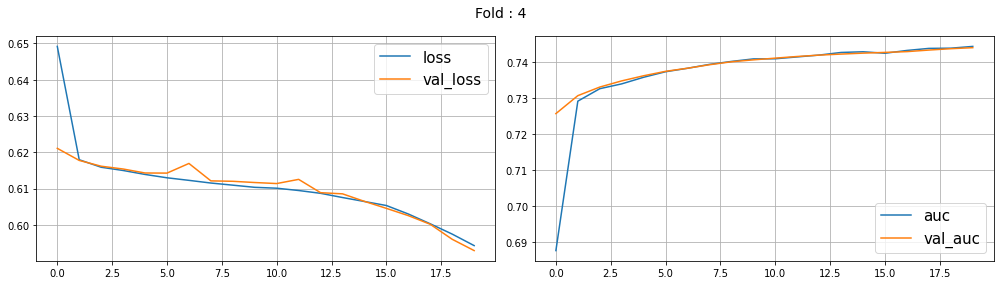

In [6]:
import matplotlib.pyplot as plt

for fold in range(f_scores['folds'].nunique()):
    history_f = f_scores[f_scores['folds'] == fold]

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(14,4))
    fig.suptitle('Fold : '+str(fold), fontsize=14)
        
    plt.subplot(1,2,1)
    plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
    plt.legend(fontsize=15)
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(history_f.loc[:, ['auc', 'val_auc']],label= ['auc', 'val_auc'])
    plt.legend(fontsize=15)
    plt.grid()
    
    print("Validation Loss: {:0.4f}".format(history_f['val_loss'].min()));

In [7]:
sub = pd.read_csv("sample_submission.csv")
sub['target'] = np.mean(preds_test, axis = 0)
sub.to_csv('submission.csv', index=False)
sub.head()

,id,target
0,600000,0.740750
1,600001,0.609458
2,600002,0.797799
3,600003,0.570585
4,600004,0.606356
